In [ ]:
!pip install transformers datasets numpy pandas tokenizers sentence_splitter sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.9 MB/s eta 0:00:00


In [176]:
import os
import torch

from torch.utils.data import DataLoader, random_split, Dataset
from torch.nn.utils.rnn import pad_sequence

from transformers import GPT2LMHeadModel, GPT2Config, ElectraTokenizerFast
from datasets import load_dataset

In [ ]:
class Config:
    epoch              = 20
    lr                 = 5e-5
    train_size         = 0.9  # Training = 90%; Validation = 10%
    data_sample_size   = 1000 # None = full
    dataset_block_size = 512
    device             = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size         = 4

In [148]:
class GeorgianDataset(Dataset):
    def __init__(self,
                 tokenizer,
                 data,
                 block_size = Config.dataset_block_size):

        self.data = self.prepare_dataset(tokenizer, data, block_size)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return torch.tensor(self.data[item], dtype=torch.long)

    def prepare_dataset(self, tokenizer, data, block_size):
        block_size = block_size - (tokenizer.model_max_length - tokenizer.max_len_single_sentence)
        return [tokenizer.encode(f'{text}{tokenizer.eos_token}', max_length=block_size, truncation=True) for text in data]

In [183]:
class GPT2GeoLMHead:
    def __init__(self, model, tokenizer):
        self.device = Config.device
        self.model = model.to(self.device)
        self.tokenizer = tokenizer

        special_tokens = {
            'pad_token': '<pad>',
            'eos_token': '<eos>',
            'mask_token': '<mask>'
        }

        self.tokenizer.add_special_tokens(special_tokens)
        self.model.resize_token_embeddings(len(self.tokenizer))


    def __repr__(self):
        return '🇬🇪 <GPT2GeoLMHead>'


    def collate_batch(self, batch):
        return pad_sequence(
            batch,
            batch_first = True,
            padding_value = self.tokenizer.pad_token_id
        )


    def train(self,
              train_dataset,
              val_dataset,
              epochs = 5,
              batch_size = Config.batch_size,
              learning_rate = Config.lr):

        train_dataloader = DataLoader(
            train_dataset,
            batch_size = batch_size,
            shuffle = True,
            collate_fn = self.collate_batch
        )

        val_dataloader = DataLoader(
            val_dataset,
            batch_size = batch_size,
            collate_fn = self.collate_batch
        )

        optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate)
        criterion = torch.nn.CrossEntropyLoss()

        print('✨ Starting training...')

        for epoch in range(epochs):
            self.train_one_epoch(train_dataloader, optimizer, criterion)
            avg_val_loss = self.validate(val_dataloader)

            print(f'🍀 Epoch {epoch + 1}/{epochs}, Avg Validation Loss: {avg_val_loss}')

        print('🚀 Training complete! ')


    def train_one_epoch(self, dataloader, optimizer, criterion):
        self.model.train()

        for batch in dataloader:
            optimizer.zero_grad()
            input_ids = batch.to(self.device)
            labels = input_ids.clone()
            outputs = self.model(input_ids, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()


    def validate(self, dataloader):
        self.model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch.to(self.device)
                labels = input_ids.clone()
                outputs = self.model(input_ids, labels=labels)
                total_val_loss += outputs.loss.item()

        return total_val_loss / len(dataloader)


    def inference(self,
                  prompt,
                  max_length=100,
                  num_beams=5,
                  no_repeat_ngram_size=2,
                  top_k=50,
                  top_p=0.95,
                  temperature=0.7):

        input_ids = self.tokenizer.encode(prompt, return_tensors='pt').to(self.device)
        output = self.model.generate(
            input_ids,
            max_length=max_length,
            num_beams=num_beams,
            no_repeat_ngram_size=no_repeat_ngram_size,
            top_k=top_k,
            top_p=top_p,
            temperature=temperature
        )

        return self.tokenizer.decode(output[0], skip_special_tokens=True)


    def model(self):
        return self.model


    def tokenizer(self):
        return self.tokenizer


    def save_pretrained(self, directory):
        self.model.save_pretrained(directory)
        self.tokenizer.save_pretrained(directory)

In [162]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = ElectraTokenizerFast.from_pretrained('jnz/electra-ka')
dataset = load_dataset('wikimedia/wikipedia', '20231101.ka', split='train')

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

In [190]:
text_data = dataset['text'][:Config.data_sample_size] if Config.data_sample_size is not None else dataset['text']
geo_dataset = GeorgianDataset(tokenizer, text_data)

In [191]:
train_size = int(Config.train_size * len(geo_dataset))
val_size = len(geo_dataset) - train_size
train_dataset, val_dataset = random_split(geo_dataset, [train_size, val_size])

In [193]:
trainer = GPT2GeoLMHead(model, tokenizer)
trainer

🇬🇪 <GPT2GeoLMHead>

In [194]:
trainer.train(train_dataset, val_dataset, epochs=20)

✨ Starting training...
🍀 Epoch 1/20, Avg Validation Loss: 4.4096415328979495
🍀 Epoch 2/20, Avg Validation Loss: 4.0400551986694335
🍀 Epoch 3/20, Avg Validation Loss: 3.7256241607666016
🍀 Epoch 4/20, Avg Validation Loss: 3.4831838274002074
🍀 Epoch 5/20, Avg Validation Loss: 3.3202856588363647
🍀 Epoch 6/20, Avg Validation Loss: 3.1963883590698243
🍀 Epoch 7/20, Avg Validation Loss: 3.0879679822921755
🍀 Epoch 8/20, Avg Validation Loss: 3.0517963314056398
🍀 Epoch 9/20, Avg Validation Loss: 2.9590879249572755
🍀 Epoch 10/20, Avg Validation Loss: 2.911051936149597
🍀 Epoch 11/20, Avg Validation Loss: 2.86656708240509
🍀 Epoch 12/20, Avg Validation Loss: 2.8225837326049805
🍀 Epoch 13/20, Avg Validation Loss: 2.8199718713760378
🍀 Epoch 14/20, Avg Validation Loss: 2.786826324462891
🍀 Epoch 15/20, Avg Validation Loss: 2.739869251251221
🍀 Epoch 16/20, Avg Validation Loss: 2.762516198158264
🍀 Epoch 17/20, Avg Validation Loss: 2.752155303955078
🍀 Epoch 18/20, Avg Validation Loss: 2.727369623184204
🍀 Ep

In [196]:
generated_text = trainer.inference('ქართულ მითოლოგიაში ')

print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ქართულ მითოლოგიაში, მითების პერსონაჟები და. მითები დაკავშირებული მითური წარმოშობას, რომელიც წარმოიშვა მითი გარემოც, რომ ამ პერიოდში და სხვა სხვა. აგრეთვე მითიდან წარმოადგენს მითებთან ერთად, როგორც საშუალებები, საფუძვლად წარმოების წარსულში. ლიტერატურა წარმომავლობებს მით


In [197]:
!pip install seaborn matplotlib

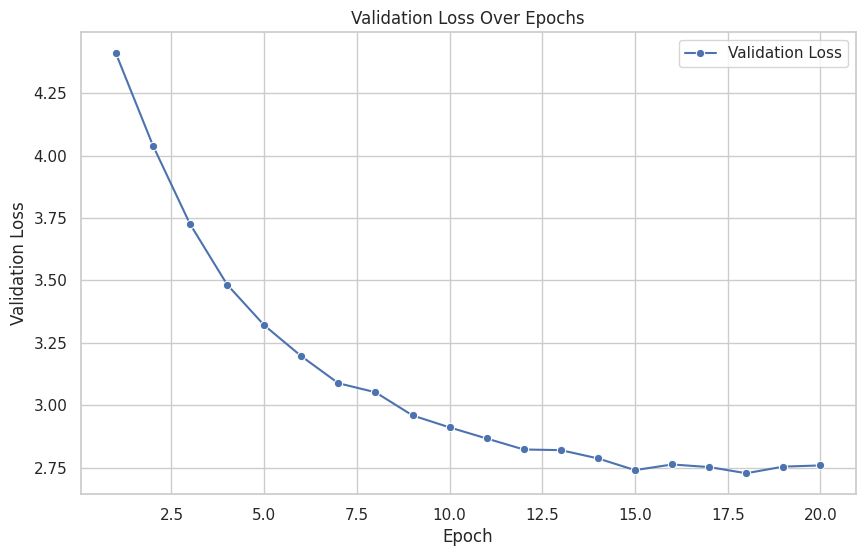

In [200]:
import seaborn as sns
import matplotlib.pyplot as plt

epoch_numbers = list(range(1, 21))
validation_losses = [
    4.4096415328979495,
    4.0400551986694335,
    3.7256241607666016,
    3.4831838274002074,
    3.3202856588363647,
    3.1963883590698243,
    3.0879679822921755,
    3.0517963314056398,
    2.9590879249572755,
    2.911051936149597,
    2.86656708240509,
    2.8225837326049805,
    2.8199718713760378,
    2.786826324462891,
    2.739869251251221,
    2.762516198158264,
    2.752155303955078,
    2.727369623184204,
    2.753919563293457,
    2.758682017326355
]

sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.lineplot(x=epoch_numbers, y=validation_losses, marker='o', label='Validation Loss')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()